In [128]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, LeakyReLU
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam
import cv2
from utils.video_decoding import VideoDecoder
import time
import ast
import os

In [129]:
class Dataset:

    def __init__(self):
        self.images_folder = "images/"
        self.labels_folder = "labels/"
        self.image_files = os.listdir(self.images_folder)
        self.label_files = os.listdir(self.labels_folder)
        self.data_set_size = len(self.image_files)

    def print_data(self):
        for i in range(len(self.image_files)):
            print(self.image_files[i], self.label_files[i])

    def generate_dateset(self):
        for i in range(len(self.image_files)):
            a_data = self.image_label(i)
            if a_data is None:
                continue
            else:
                yield a_data

    def image_label(self, index):
        image = self.load_image(self.image_files[index]) / 255
        image = image.astype(np.float32)
        with open("labels/" + self.label_files[index], "r") as f:
            data = f.readlines()
        if len(data) == 0:
            return None
        label = pd.read_csv("labels/" + self.label_files[index], header=None, delimiter=" ")
        label.iloc[:, 1:] = label.iloc[:, 1:] * 224
        label = label.iloc[:, 1:]
        label = label.to_numpy()
        label = label.astype(np.float32)
        return image, label

    def load_image(self, image_file):
        image = cv2.imread(f"{self.images_folder}/{image_file}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image.reshape(1, 224, 224, 3)
        return image

In [130]:
def create_dataset():
    dataset = Dataset()
    for count, (image, label) in enumerate(dataset.generate_dateset()):
        if count == 0:
            x_data = np.array(image)
            y_data = np.array(label)
        else:
            x_data = np.concatenate((x_data, image), axis=0)
            y_data = np.concatenate((y_data, label), axis=0)

    return x_data, y_data

In [131]:
x_data, y_data = create_dataset()
x_data.shape

(46, 224, 224, 3)

In [144]:
def draw_image_with_box(data_set_x:np.ndarray, data_set_y:np.ndarray):
    def one_image(x_data:np.ndarray, y_data:np.ndarray) -> np.ndarray:
        image = x_data
        x = int(y_data[0]) - int(y_data[2] / 2)
        y = int(y_data[1]) + int(y_data[3] / 2)
        box_width = int(x + y_data[2])
        box_height = int(y - y_data[3])
        cv2.rectangle(image, (x, y), (box_width, box_height), (0, 255, 0), 2)
        print(image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image *= 255
        return image

    for i in range(len(x_test)):
        cv2.imwrite(f"test_images/{i}.jpg", one_image(data_set_x[i], data_set_y[i]))

In [133]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [134]:
x_train.shape

(36, 224, 224, 3)

In [135]:
y_train.shape

(36, 4)

In [136]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False, input_shape=(224, 224, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='linear'))
model.add(Dropout(0.3))
model.add(Dense(4))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 224, 224, 32)      864       
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 224, 224, 32)      0         
                                                                 
 batch_normalization_60 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_61 (Conv2D)          (None, 224, 224, 32)      9216      
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 224, 224, 32)      0         
                                                                 
 batch_normalization_61 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                     

In [137]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])

In [138]:
hist = model.fit(x_train, y_train, batch_size=1,validation_data=(x_test, y_test) ,epochs=100, verbose=2, shuffle=True)

Epoch 1/100
36/36 - 2s - loss: 2487.5020 - mse: 2487.5020 - val_loss: 9302.4395 - val_mse: 9302.4395 - 2s/epoch - 53ms/step
Epoch 2/100
36/36 - 1s - loss: 2690.4744 - mse: 2690.4744 - val_loss: 1184.9080 - val_mse: 1184.9080 - 544ms/epoch - 15ms/step
Epoch 3/100
36/36 - 1s - loss: 2937.9502 - mse: 2937.9502 - val_loss: 3440309.5000 - val_mse: 3440309.5000 - 554ms/epoch - 15ms/step
Epoch 4/100
36/36 - 1s - loss: 2867.9575 - mse: 2867.9575 - val_loss: 4238825.5000 - val_mse: 4238825.5000 - 547ms/epoch - 15ms/step
Epoch 5/100
36/36 - 1s - loss: 2287.7043 - mse: 2287.7043 - val_loss: 48957.1211 - val_mse: 48957.1211 - 550ms/epoch - 15ms/step
Epoch 6/100
36/36 - 1s - loss: 1442.9124 - mse: 1442.9124 - val_loss: 15089.8545 - val_mse: 15089.8545 - 541ms/epoch - 15ms/step
Epoch 7/100
36/36 - 1s - loss: 2895.2034 - mse: 2895.2034 - val_loss: 486.4400 - val_mse: 486.4400 - 532ms/epoch - 15ms/step
Epoch 8/100
36/36 - 1s - loss: 1964.4338 - mse: 1964.4338 - val_loss: 382.0745 - val_mse: 382.0745 -

In [139]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 205ms/step - loss: 359.1100 - mse: 359.1100


[359.1099548339844, 359.1099548339844]

In [140]:
hist.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

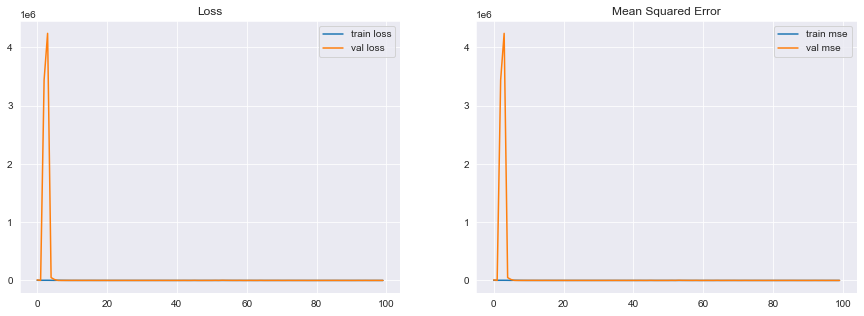

In [141]:
# plot the training loss and accuracy
ax, fig = plt.subplots(1, 2, figsize=(15, 5))
fig[0].plot(hist.history['loss'], label='train loss')
fig[0].plot(hist.history['val_loss'], label='val loss')
fig[0].set_title('Loss')
fig[0].legend()
fig[1].plot(hist.history['mse'], label='train mse')
fig[1].plot(hist.history['val_mse'], label='val mse')
fig[1].set_title('Mean Squared Error')
fig[1].legend()
plt.show()

In [142]:
y_pred = model.predict(x_test)

1/1 [==============================] - 0s 187ms/step


In [145]:
draw_image_with_box(x_test, y_pred)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
